In [ ]:
!pip3 install asrtoolkit --user
!pip3 install fuzzywuzzy --user
!pip3 install python-Levenshtein --user
!pip3 install nltk

import asrtoolkit
from fuzzywuzzy import fuzz
import io
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
from nltk.metrics import distance

In [10]:
filenames = list(Path('predictions').glob('*.csv'))

results = pd.DataFrame()
models = list()

for idx, filename in enumerate(filenames):
    new_results = pd.read_csv(filename)
    model_label = Path(filename).stem.split('-')[0]
    ground_truth_label = f'{model_label}-ground_truth'
    new_results = new_results.rename(columns={'label': ground_truth_label, 
                            'prediction': model_label})
    del new_results['Unnamed: 0']
    models.append((ground_truth_label, model_label))
    new_results[ground_truth_label] = new_results.apply(lambda r: str(r[ground_truth_label]), axis=1)
    new_results[model_label] = new_results.apply(lambda r: str(r[model_label]), axis=1)
    results = pd.concat([results, new_results], axis = 1)

results

,run_55_all-ground_truth,run_55_all
0,A,A
1,more,more
2,a,a
3,Foot,Foot
4,and,and
...,...,...
145,.,.
146,.,.
147,have,have
148,said,said


In [11]:
summary_results = pd.DataFrame()

for ground_truth_label, model_label in models:
    cer_label = f'{model_label} CER'
    subset = results[[ground_truth_label, model_label]].dropna()
    results[cer_label] = subset.apply(lambda r: asrtoolkit.cer(str(r[ground_truth_label]), str(r[model_label])), axis=1)
    summary_results.loc[model_label, 'CER_average'] = results[cer_label].mean(skipna=True)
    summary_results.loc[model_label, 'CER_stdev'] = results[cer_label].std(skipna=True)
    summary_results.loc[model_label, 'CER_min'] = results[cer_label].min(skipna=True)
    summary_results.loc[model_label, 'CER_median'] = results[cer_label].median(skipna=True)
    summary_results.loc[model_label, 'CER_max'] = results[cer_label].max(skipna=True)

    ratio_label = f'{model_label} match ratio'
    results[ratio_label] = subset.apply(lambda r: fuzz.ratio(str(r[ground_truth_label]), str(r[model_label])), axis=1)
    summary_results.loc[model_label, 'matchratio_average'] = results[ratio_label].mean()
    summary_results.loc[model_label, 'matchratio_stdev'] = results[ratio_label].std(skipna=True)
    summary_results.loc[model_label, 'matchratio_min'] = results[ratio_label].min(skipna=True)
    summary_results.loc[model_label, 'matchratio_median'] = results[ratio_label].median(skipna=True)
    summary_results.loc[model_label, 'matchratio_max'] = results[ratio_label].max(skipna=True)
    subset[ratio_label] = results[ratio_label]

    exact = subset.apply(lambda r: 1 if str(r[ground_truth_label]) == str(r[model_label]) else 0, axis=1).sum()
    oboe = subset.apply(lambda r: 1 if int((len(r[ground_truth_label]) + len(r[model_label])) - \
                                            r[f'{model_label} match ratio'] / 100 * \
                                            (len(r[ground_truth_label]) + len(r[model_label]))) == 1 else 0,
                        axis=1).sum()
    summary_results.loc[model_label, 'exact_matches'] = exact
    summary_results.loc[model_label, 'oboe_matches'] = oboe
        
    ci=0.95
    err_range = stats.norm.interval(alpha=ci, 
                                  loc=np.mean(results[f'{model_label} CER'].dropna()), 
                                  scale=stats.sem(results[f'{model_label} CER'].dropna()))
    summary_results.loc[model_label, 'cer_95_error_min'] = err_range[0]
    summary_results.loc[model_label, 'cer_95_error_max'] = err_range[1]

summary_results['exact_matches'] = pd.to_numeric(summary_results['exact_matches'], downcast='integer')
summary_results['oboe_matches'] = pd.to_numeric(summary_results['oboe_matches'], downcast='integer')

summary_results

,CER_average,CER_stdev,CER_min,CER_median,CER_max,matchratio_average,matchratio_stdev,matchratio_min,matchratio_median,matchratio_max,exact_matches,oboe_matches,cer_95_error_min,cer_95_error_max
run_55_all,1.025421,4.608052,0.0,0.0,33.333333,96.62,16.445831,0.0,100.0,100.0,138,5,0.287993,1.762849


/opt/conda/bin/ipython:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  # -*- coding: utf-8 -*-
/opt/conda/bin/ipython:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/bin/ipython:28: UserWarning: FixedFormatter should only be used together with FixedLocator


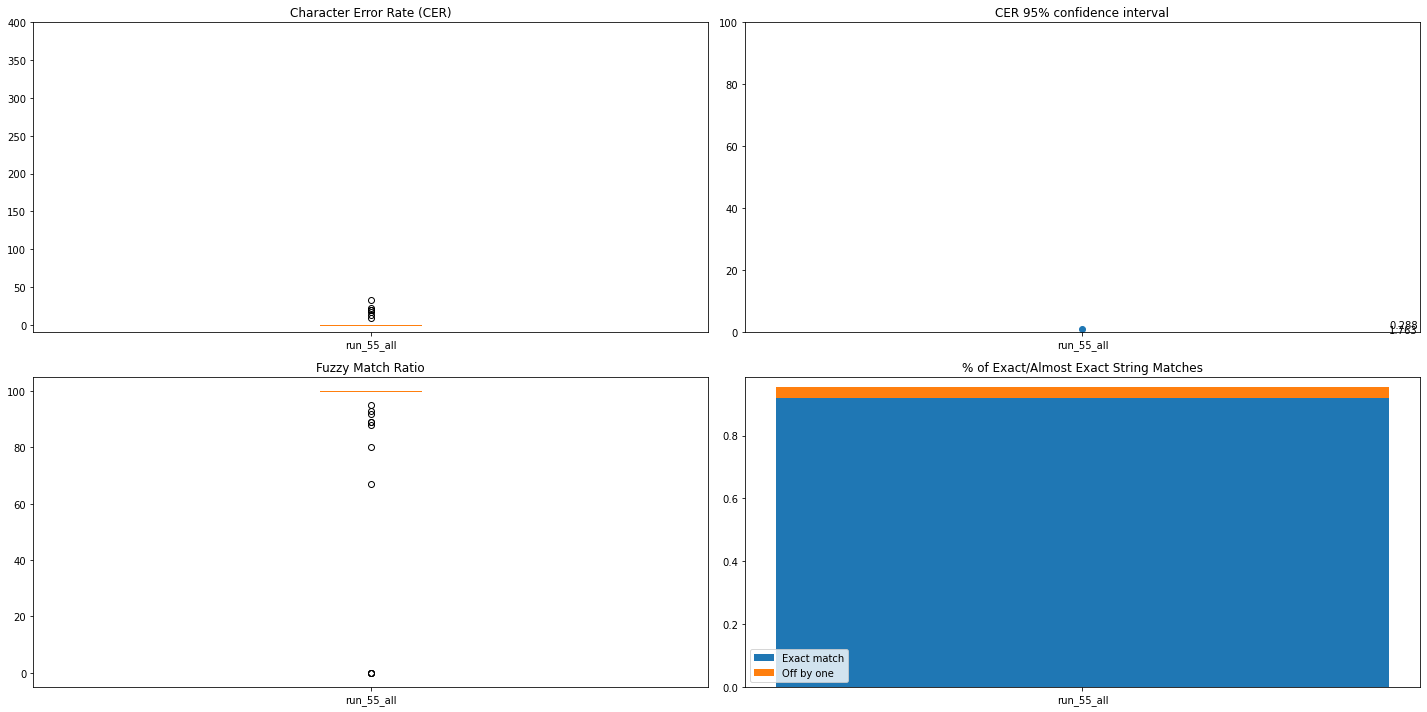

In [12]:
def plot_cer(graph):
    graph.set_title('Character Error Rate (CER)')
    graph.set_xticklabels([label[1] for label in models])
    graph.set_ylim([-10, 400])
    subset = results[[f'{label[1]} CER' for label in models]].T
    subset = np.asarray([model[1].dropna() for model in subset.iterrows()], dtype=object).T
    graph = graph.boxplot(subset)


def plot_cer_confidence_interval(graph):
    min = summary_results['cer_95_error_min']
    min = min.apply(lambda v: v if v >= 0 else 0)
    max = summary_results['cer_95_error_max']
    max = max.apply(lambda v: v if v <= 100 else 100)
    error_min = [summary_results.loc[label[1], 'CER_average'] - min[label[1]] for label in models]
    error_max = [max[label[1]] - summary_results.loc[label[1], 'CER_average'] for label in models]
    graph.set_title('CER 95% confidence interval')
    graph.set_xticklabels([label[1] for label in models])
    graph.set_ylim(top=100)
    graph.errorbar([label[1] for label in models], summary_results['CER_average'], yerr=[error_min, error_max], fmt='o')
    for i in range(len(models)):
        graph.text(i + 0.05, max[i] - 2, f'{max[i]:.3f}')
        graph.text(i + 0.05, min[i] + 1, f'{min[i]:.3f}')


def plot_fuzzy_match(graph):
    graph.set_title('Fuzzy Match Ratio')
    graph.set_xticklabels([label[1] for label in models])
    subset = results[[f'{label[1]} match ratio' for label in models]].T
    subset = np.asarray([model[1].dropna() for model in subset.iterrows()], dtype=object).T
    graph = graph.boxplot(subset)


def plot_close_matches(graph):
    graph.set_title('% of Exact/Almost Exact String Matches')
    exact_matches = [match/results.shape[0] for match in summary_results['exact_matches']]
    obo_matches = [match/results.shape[0] for match in summary_results['oboe_matches']]
    ex = graph.bar([label[1] for label in models], exact_matches, 
                   width=0.3, label='Exact match')
    obo = graph.bar([label[1] for label in models], obo_matches, 
                    width=0.3, bottom=exact_matches, label='Off by one')
    height = int(summary_results['exact_matches'].max()) + int(summary_results['oboe_matches'].max()) + 5
    graph.set_ybound(0, height/results.shape[0])
    graph.legend()


fig, ((graph1, graph2), (graph3, graph4)) = plt.subplots(2, 2, figsize=(20, 10))
# fig, graph1 = plt.subplots(1, 1, figsize=(10, 7))  # For saving individual charts

plot_cer(graph1)
plot_cer_confidence_interval(graph2)
plot_fuzzy_match(graph3)
plot_close_matches(graph4)
fig.tight_layout()